# ACS2 in Cart Pole Environment

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import gym

import pandas as pd
import numpy as np

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../'))

from lcs.agents import EnvironmentAdapter
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList
from lcs.metrics import population_metrics


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trials = 30_000
bins = 14

## Environment

In [3]:
env = gym.make('CartPole-v0')

Try some random steps to get min/max of each observation

In [4]:
%%time

steps = 10000

obs_arr = np.zeros((steps, 4))

for i in range(steps):
    env.reset()
    done = False
    while not done:
        obs, reward, done, _ = env.step(env.action_space.sample())
        obs_arr[i, :] = obs

env.close()

CPU times: user 4.19 s, sys: 33.7 ms, total: 4.22 s
Wall time: 4.23 s


For discretization calculate the range between variables

In [5]:
_high = obs_arr.max(axis=0)
_low = obs_arr.min(axis=0)

_range = _high - _low
_range

array([2.51373588, 5.89561808, 0.53491944, 6.79859254])

## Agent configuration

In [6]:
class CartPoleAdapter(EnvironmentAdapter):
    BINS = bins
    
    @classmethod
    def to_genotype(cls, obs):
        return np.round(((obs - _low) / _range) * cls.BINS).astype(int).astype(str)

In [7]:
def print_cl(cl):
    action = None
    marked = ''
    
    if cl.action == 0:
        action = 'L'
    if cl.action == 1:
        action = 'R'
    
    if cl.is_marked():
        marked = '(*)'
    
    return (f"{cl.condition} - {action} - {cl.effect} [fit: {cl.fitness:.3f}, r: {cl.r:.2f}, ir: {cl.ir:.2f}] {marked}")

## Evaluation metrics

In [8]:
def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable()])

# collect more metrics
def cp_metrics(pop, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(pop)
    metrics.update(population_metrics(pop, env))
    
    return metrics

# ACS2 Configuration

In [9]:
cfg = Configuration(
            classifier_length=4,
            number_of_possible_actions=2,
            epsilon=0.9,
            beta=0.05,
            gamma=0.95,
            theta_exp=50,
            theta_ga=50,
            do_ga=True,
            mu=0.03,
            u_max=4,
            metrics_trial_frequency=5,
            user_metrics_collector_fcn=cp_metrics,
            environment_adapter=CartPoleAdapter)

In [10]:
%%time

agent = ACS2(cfg)
population_explore, metrics_explore = agent.explore(env, trials, decay=True)

/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 14, 'reward': 1.0, 'avg_fitness': nan, 'population': 14, 'numerosity': 14, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 3000, 'steps_in_trial': 50, 'reward': 1.0, 'avg_fitness': 2.660980655914601, 'population': 4892, 'numerosity': 12243, 'reliable': 12}
INFO:lcs.agents.Agent:{'trial': 6000, 'steps_in_trial': 20, 'reward': 1.0, 'avg_fitness': 2.538289759593459, 'population': 6537, 'numerosity': 16712, 'reliable': 17}
INFO:lcs.agents.Agent:{'trial': 9000, 'steps_in_trial': 21, 'reward': 1.0, 'avg_fitness': 2.4595304645774005, 'population': 7697, 'numerosity': 19894, 'reliable': 22}
INFO:lcs.agents

CPU times: user 7h 53min 18s, sys: 1min 39s, total: 7h 54min 58s
Wall time: 9h 48min 23s


In [11]:
print(len(population_explore))

11246


In [12]:
for cl in sorted(population_explore, key=lambda cl: -cl.fitness)[:30]:
    print(print_cl(cl))

8877 - R - ###6 [fit: 4.739, r: 4.86, ir: 1.00] 
8867 - R - ###6 [fit: 4.670, r: 5.09, ir: 1.00] 
8787 - R - #8## [fit: 4.416, r: 4.53, ir: 1.00] 
7#77 - R - ###6 [fit: 4.078, r: 4.25, ir: 0.97] 
8876 - L - ###7 [fit: 3.974, r: 5.48, ir: 1.00] 
8866 - L - ###7 [fit: 3.954, r: 4.99, ir: 1.00] 
7877 - R - ###6 [fit: 3.822, r: 3.94, ir: 1.00] 
887# - R - ###6 [fit: 3.722, r: 4.86, ir: 1.00] (*)
8897 - R - #### [fit: 3.717, r: 4.32, ir: 1.00] 
7#66 - L - 8##7 [fit: 3.695, r: 4.52, ir: 0.94] (*)
7867 - R - ###6 [fit: 3.668, r: 3.84, ir: 1.00] 
8886 - L - ###7 [fit: 3.622, r: 4.41, ir: 1.00] 
8847 - L - #7## [fit: 3.562, r: 3.57, ir: 1.00] 
7866 - L - 8##7 [fit: 3.429, r: 4.55, ir: 1.00] 
8897 - L - #7#8 [fit: 3.413, r: 4.03, ir: 1.00] 
7787 - L - ###8 [fit: 3.403, r: 3.51, ir: 1.00] 
8758 - R - ##67 [fit: 3.334, r: 4.22, ir: 1.00] 
8897 - R - ###6 [fit: 3.296, r: 4.32, ir: 1.00] 
7897 - L - #7#8 [fit: 3.262, r: 3.61, ir: 1.00] 
8798 - R - #8#7 [fit: 3.238, r: 4.27, ir: 1.00] 
8788 - R - #8#

In [13]:
metrics_df = pd.DataFrame(metrics_explore)
metrics_df.set_index('trial', inplace=True)

## Plots

In [14]:
# for plots
window = 100
figsize=(14,6)

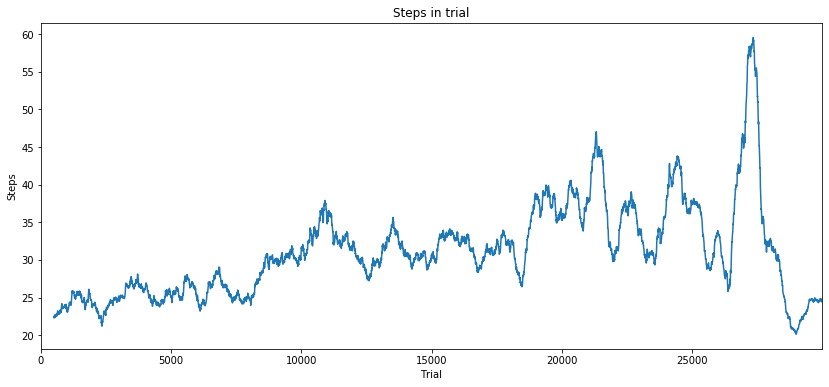

Avg steps 30.9985


In [15]:
fig, ax = plt.subplots(figsize=figsize)

metrics_df['steps_in_trial'].rolling(window=window).mean().plot();
ax.set_title('Steps in trial')
ax.set_xlabel('Trial')
ax.set_ylabel('Steps')

plt.show()

print(f"Avg steps {metrics_df['steps_in_trial'].mean()}")

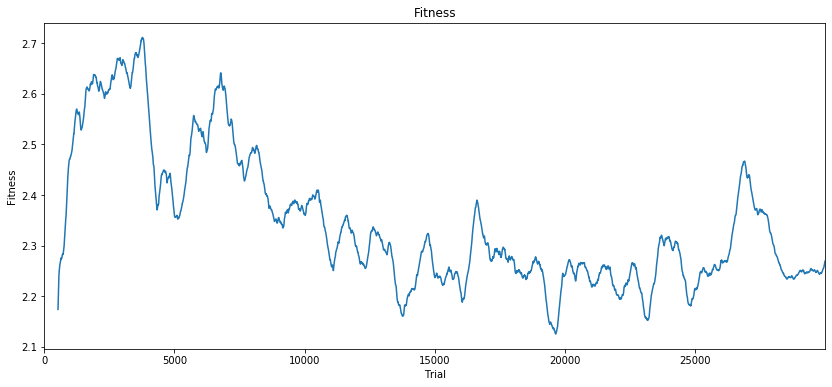

In [16]:
fig, ax = plt.subplots(figsize=figsize)

metrics_df['avg_fitness'].rolling(window=window).mean().plot();
ax.set_title('Fitness')
ax.set_xlabel('Trial')
ax.set_ylabel('Fitness')

plt.show()

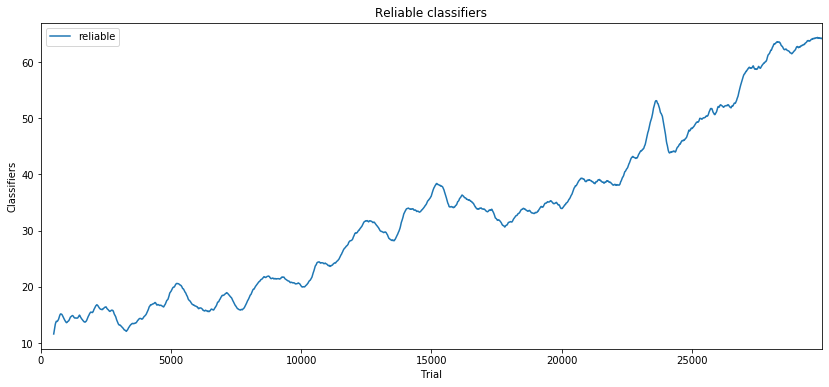

In [17]:
fig, ax = plt.subplots(figsize=figsize)

# metrics_df['population'].rolling(window=window).mean().plot(label='population', ax=ax)
metrics_df['reliable'].rolling(window=window).mean().plot(label='reliable', ax=ax)

ax.set_title('Reliable classifiers')
ax.set_xlabel('Trial')
ax.set_ylabel('Classifiers')

plt.legend()
plt.show()